<a href="https://colab.research.google.com/github/RAV10K1/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_7_Ravindra_Tennekone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [90]:
# Checking train dataset
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
50129,1230195,IRAZU INC,IRAZU INC,22758.0,Restaurant,Risk 1 (High),1865 N MILWAUKEE AVE,CHICAGO,IL,60647.0,2012-07-19T00:00:00,Short Form Complaint,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.915385,-87.684974,"{'longitude': '-87.68497371798973', 'latitude'...",0
6026,1322226,EVERGREEN RESTAURANT,EVERGREEN RESTAURANT,2185077.0,Restaurant,Risk 1 (High),2411 S WENTWORTH AVE,CHICAGO,IL,60616.0,2012-11-28T00:00:00,License Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.848805,-87.631778,"{'longitude': '-87.63177773474666', 'latitude'...",0
31408,1215193,La Isla Pequena,La Isla Pequena,2137994.0,Restaurant,Risk 1 (High),4107 W NORTH AVE,CHICAGO,IL,60639.0,2012-05-25T00:00:00,Short Form Complaint,NaN,41.909736,-87.729273,"{'longitude': '-87.72927346612649', 'latitude'...",0
20730,1547096,HON KEE REST INC,HON KEE RESTAURANT,2751.0,Restaurant,Risk 1 (High),1064 W ARGYLE ST,CHICAGO,IL,60640.0,2015-06-15T00:00:00,Suspected Food Poisoning,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.973386,-87.657509,"{'longitude': '-87.65750874906352', 'latitude'...",1
11070,634370,DUNLAYS ON THE SQUARE,MERCHANT,1046040.0,Restaurant,Risk 1 (High),3137-3139 W LOGAN BLVD,CHICAGO,IL,60647.0,2011-08-23T00:00:00,Canvass Re-Inspection,36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF...,41.927864,-87.706415,"{'longitude': '-87.70641510084438', 'latitude'...",0


In [91]:
# Checking test dataset
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


In [92]:
# Checking column labels
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [93]:
# Checking for Null Values
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            484
License #             2
Facility Type       181
Risk                 10
Address               0
City                 42
State                 9
Zip                  17
Inspection Date       0
Inspection Type       1
Violations         7741
Latitude            150
Longitude           150
Location            150
Fail                  0
dtype: int64

### Calculating Majority Class Baseline

In [94]:
train['Fail'].value_counts(normalize=True)

0    0.740561
1    0.259439
Name: Fail, dtype: float64

According to the majority class baseline, 74% of businesses passed inspection with 26% failing.

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [95]:
# Splitting train dataset into train and validation data
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size = 0.8, test_size = 0.2)

train.shape, val.shape

((33225, 17), (8307, 17))

In [0]:
# Arranging data into X matrices and y vectors
target = 'Fail'
features = train.columns.drop(labels=['Inspection ID', 'DBA Name', 'AKA Name', 
                                       'License #', 'Address', target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [97]:
# Creating Pipeline for Modelling
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk', 'City', 'State',
                                      'Inspection Date', 'Inspection Type',
                                      'Violations', 'Location'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Daycare Above and Under 2 Years      1
Restaurant                           2
Daycare Combo 1586                   3
S...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=

In [98]:
# Predicting test data using model
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.15, 0.7 , 0.03, ..., 0.13, 0.05, 0.02])

In [99]:
from sklearn.metrics import roc_auc_score
print(f'ROC AUC Score : {roc_auc_score(y_test, y_pred_proba):.2f}')

ROC AUC Score : 0.64


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

### Permutation Importances

For model interpretation permutation importance is looked at for the features using eli5 library.

In [100]:
transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer()
)

X_train_tranformed = transformers.fit_transform(X_train)
X_val_tranformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_tranformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [101]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring=None,
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_tranformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [102]:
# Displaying feature importances
feature_names = X_val.columns.to_list()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

Inspection Type    0.008065
Facility Type      0.002937
Violations         0.000265
Inspection Date    0.000096
State              0.000000
City               0.000000
Risk              -0.000120
Latitude          -0.001396
Location          -0.002119
Zip               -0.002335
Longitude         -0.002648
dtype: float64

In [103]:
# Displaying feature weights
eli5.show_weights(permuter, 
                  top=None,
                  feature_names=feature_names)

Weight,Feature
0.0081 ± 0.0024,Inspection Type
0.0029 ± 0.0010,Facility Type
0.0003 ± 0.0002,Violations
0.0001 ± 0.0015,Inspection Date
0 ± 0.0000,State
0.0000 ± 0.0002,City
-0.0001 ± 0.0023,Risk
-0.0014 ± 0.0012,Latitude
-0.0021 ± 0.0013,Location
-0.0023 ± 0.0018,Zip


Based on the calculated feature weights the best features for prediction are inspection type and inspection date as well as violations followed by state, city, facility type, location and risk.

### Confusion Matrix

[[0.9812953  0.0187047 ]
 [0.95240223 0.04759777]]


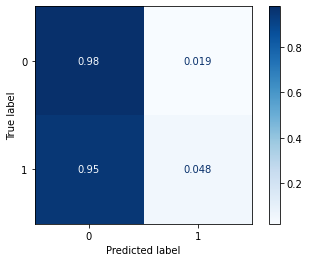

In [104]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(pipeline, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
print(disp.confusion_matrix)

plt.show()